# 01 Load libraries and data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pwd

'/content'

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

,location-long,location-lat
0,9.007295,47.729436
1,9.006664,47.728628
2,9.007286,47.728538
3,9.005811,47.728665
4,9.008257,47.728132


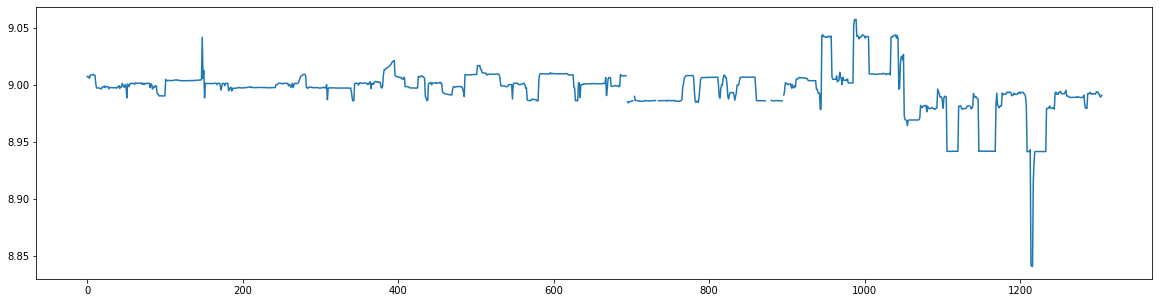

In [7]:
# just wanna show you NAs in the graph
rawdata = pd.read_csv("./drive/MyDrive/Tutoring/Lake_Constance_Ducks_XY.csv", encoding='CP949') # if you want to use another animal data, you can change this line
#rawdata = rawdata.dropna()
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["location-long"])
rawdata.head()

,location-long,location-lat
0,9.007295,47.729436
1,9.006664,47.728628
2,9.007286,47.728538
3,9.005811,47.728665
4,9.008257,47.728132


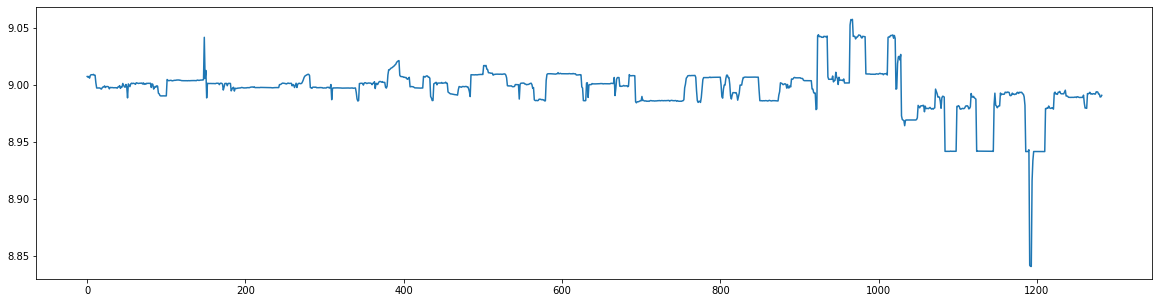

In [22]:
rawdata = pd.read_csv("./drive/MyDrive/Tutoring/Lake_Constance_Ducks_XY.csv", encoding='CP949') # if you want to use another animal data, you can change this line
rawdata = rawdata.dropna()

plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["location-long"]) # if you want to change to Y sequence modeling, you can change to location-lat instead of location-long
rawdata.head()

# 02 Data preprocessing

In [23]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["location-long"] = min_max_scaler.fit_transform(rawdata["location-long"].to_numpy().reshape(-1,1))

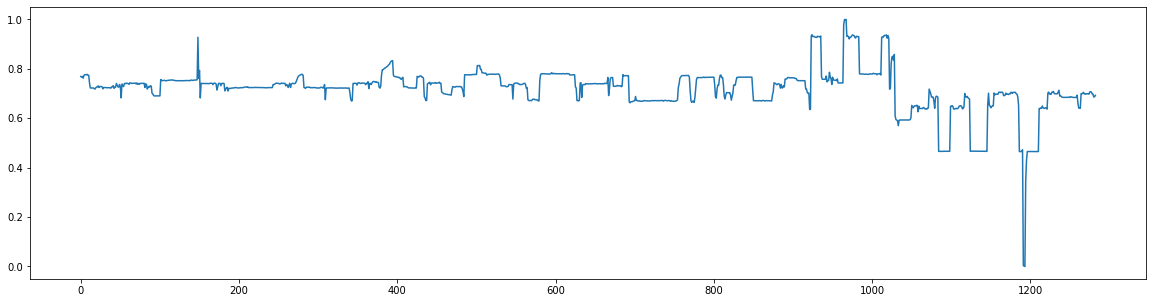

In [24]:
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["location-long"])

In [25]:
rawdata

,location-long,location-lat
0,0.768922,47.729436
1,0.766004,47.728628
2,0.768880,47.728538
3,0.762056,47.728665
4,0.773373,47.728132
...,...,...
1301,0.697925,47.728529
1302,0.697279,47.728674
1303,0.685793,47.729353
1304,0.686601,47.729179


In [26]:
train = rawdata[:-24*7]
data_train = train["location-long"].to_numpy()

test = rawdata[-24*7:]
data_test = test["location-long"].to_numpy()

In [27]:
data_train.shape

(1115,)

In [28]:
data_test.shape

(168,)

시계열 예측을 위해 데이터의 일정한 길이의 input window, output window를 설정하고, 데이터의 처음 부분부터 끝부분까지 sliding

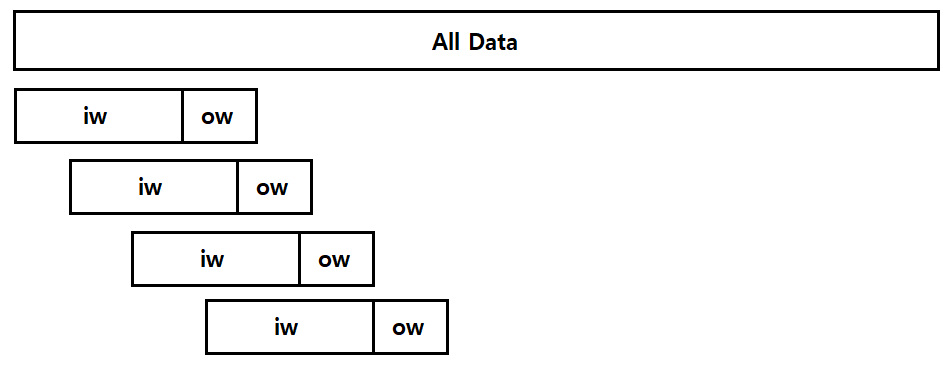

In [29]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [30]:
iw = 24*7*2
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# 03 Modeling
: transformer encoder + FC (fully connected) layer

In [31]:
from torch.nn import Transformer
from torch import nn
import torch
import math

In [32]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) # bring the layer from above
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [33]:
device = torch.device("cuda") #런타임에서 꼭 GPU를 골라야 해요
lr = 1e-4
model = TFModel(24*2*7, 24*7, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [34]:
for (inputs, outputs) in train_loader:
  print(inputs.shape)

torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([64, 336, 1])
torch.Size([36, 336, 1])


In [35]:
for (inputs, outputs) in train_loader:
  print(outputs.shape)

torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([64, 168, 1])
torch.Size([36, 168, 1])


In [36]:
from tqdm import tqdm

epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.005505: 100%|██████████| 1000/1000 [1:37:25<00:00,  5.85s/it]


In [37]:
def evaluate():
    input = torch.tensor(data_train[-24*2*7:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [38]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["location-long"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]

In [39]:
real.shape

(1283,)

In [40]:
result.shape

(168,)

In [41]:
result

array([9.002674 , 9.003245 , 9.003219 , 9.002874 , 9.003517 , 9.003285 ,
       9.003268 , 9.003584 , 9.003537 , 9.003626 , 9.003659 , 9.003507 ,
       9.003538 , 9.003378 , 9.003366 , 9.003556 , 9.002775 , 9.002928 ,
       9.003806 , 9.003464 , 9.003259 , 9.003496 , 9.003405 , 9.004033 ,
       9.003818 , 9.003613 , 9.0046015, 9.004383 , 9.004628 , 9.004591 ,
       9.004409 , 9.00481  , 9.004757 , 9.004933 , 9.0050335, 9.004679 ,
       9.005514 , 9.005666 , 9.004787 , 9.005477 , 9.005451 , 9.005377 ,
       9.005417 , 9.005766 , 9.005069 , 9.005803 , 9.005399 , 9.006266 ,
       9.005295 , 9.005428 , 9.005217 , 9.005641 , 9.005645 , 9.005301 ,
       9.005399 , 9.005595 , 9.004966 , 9.005248 , 9.005272 , 9.005647 ,
       9.005165 , 9.004998 , 9.005282 , 9.00515  , 9.004749 , 9.005132 ,
       9.005142 , 9.006124 , 9.005619 , 9.005695 , 9.005669 , 9.005239 ,
       9.005165 , 9.005738 , 9.006214 , 9.006188 , 9.00643  , 9.005872 ,
       9.006059 , 9.006368 , 9.005772 , 9.006475 , 

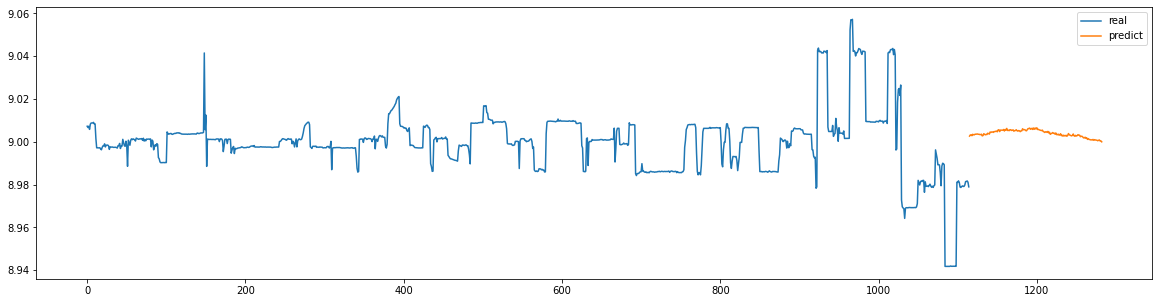

In [42]:
plt.figure(figsize=(20,5))
plt.plot(range(0,1283-24*7),real[:-24*7], label="real") #1306에서 뒤에 168 timepoint 빼고 ㄱㄱ
plt.plot(range(1283-24*7, 1283), result, label="predict")
plt.legend()
plt.show()

In [43]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

0.33525151725276525

In [45]:
np.save('./drive/MyDrive/Tutoring/duck_X_sequence.npy', result)